<a href="https://colab.research.google.com/github/oluwamark/compx310/blob/main/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1bDTd_HtxOAtEwl-Zuy9Pi_XghFtZYuVz?usp=sharing

In [1]:
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/martianunlimited/compX310_datasets/main/housing.csv"

id = 1631625

df = pd.read_csv(url)

X=df.drop(columns=['median_house_value'])
y=df['median_house_value']



###Task 1 - Function to preprocess features

In [2]:
# https://www.geeksforgeeks.org/machine-learning/data-pre-processing-wit-sklearn-using-standard-and-minmax-scaler/
# https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def preprocess_features(X):
  # Use SimpleImputer to impute missing values
  for col in X.columns:
      # Check if the column contains missing values
      if X[col].isnull().any():
          # check if column has continuous or categorical data
          if X[col].dtype in ['int64', 'float64']:
              # use 'mean' as impute value for numeriscal columns
              imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
          else:
              # use mode as impute value for catgorical values
              imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

          # ensure column is a dataframe
          col_data = X[[col]]

          # calculates mean or mode and then inserts that value
          X[col] = imputer.fit_transform(col_data)


  # transform categorical features to numeric features using OneHotEncoder

  # get all the columns with categorical data, store in list
  categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
  # initialise encoder, sparse_output=False means we get a numpy array instead of csr format
  encoder = OneHotEncoder(sparse_output=False)
  # encodes data, returns transformed array
  one_hot_encoded = encoder.fit_transform(X[categorical_columns])
  # coverts array of encoded data into a dataframe, specifies column names to be the categorical values
  encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
  # joins the two dataframes together
  x_encoded = pd.concat([X, encoded_df], axis=1)
  # remove the old categorical columns
  x_encoded = x_encoded.drop(categorical_columns, axis=1)

  # scale features using MinMaxScaler
  scaler = MinMaxScaler(feature_range=(0,1))
  model=scaler.fit(x_encoded) # finds min and max values to use for scaling
  scaled_data=model.transform(x_encoded)  # transform data onto the scaled range

  return scaled_data

###Task 2 - Function to train + test regression model

In [3]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

def run_reg(regressor, X_train, X_test, y_train, y_test):

    # train the regressor using the train data
    regressor.fit(X_train, y_train)

    # compute predictions for the test data
    y_pred = regressor.predict(X_test)

    # set predictions smaller than 15000, to 15000
    y_pred[y_pred < 15000] = 15000

    # set predictions larger than 500000 to 500000
    y_pred[y_pred > 500000] = 500000

    # compute mean absolute error for test data
    mae = mean_absolute_error(y_test, y_pred)

    # scatterplot the true test targets vs. predictions (show MAE in the plot as "title")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)  # alpha sets tranparency of points on plot
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"True Values vs. Predictions (MAE: {mae:.2f}) (cost={regressor.C}) (epsilon={regressor.epsilon})")
    plt.grid(True)
    plt.show()

    # return the MAE
    return mae

###Task 3 - Applying preprocess_features and run_reg

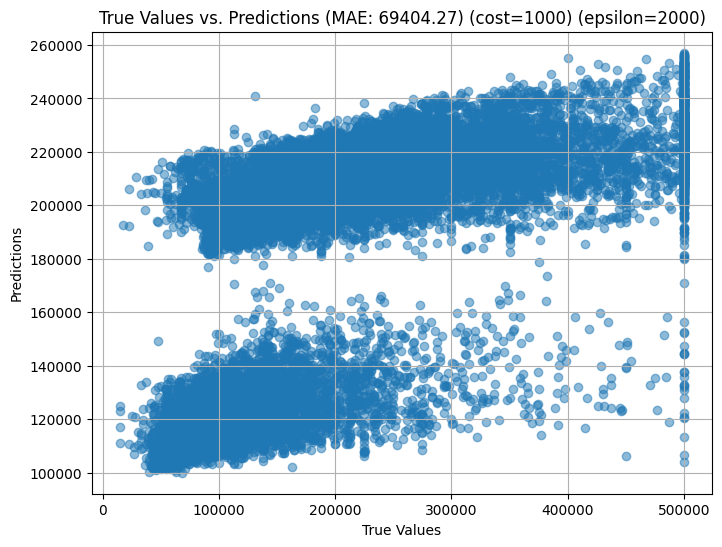

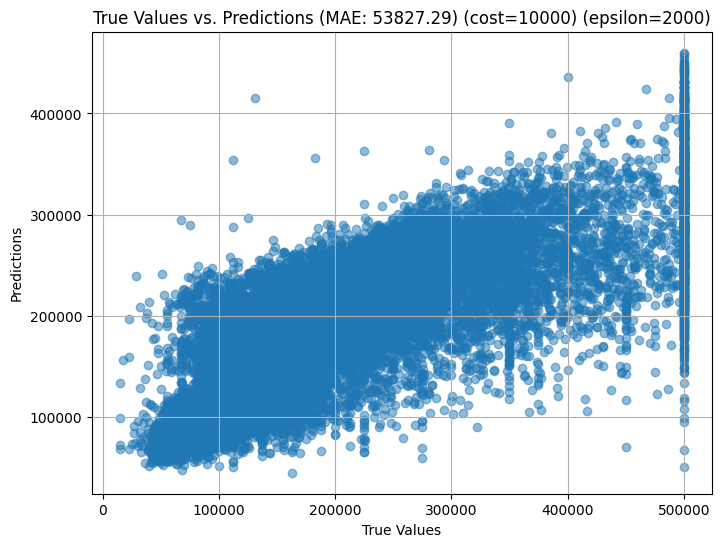

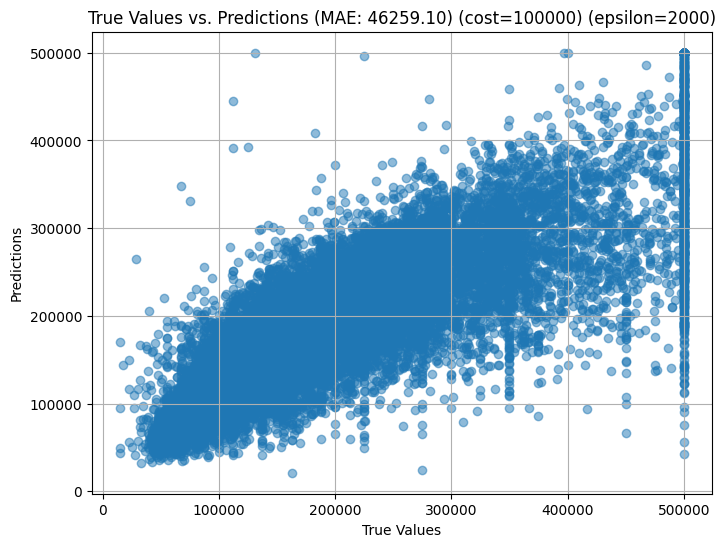

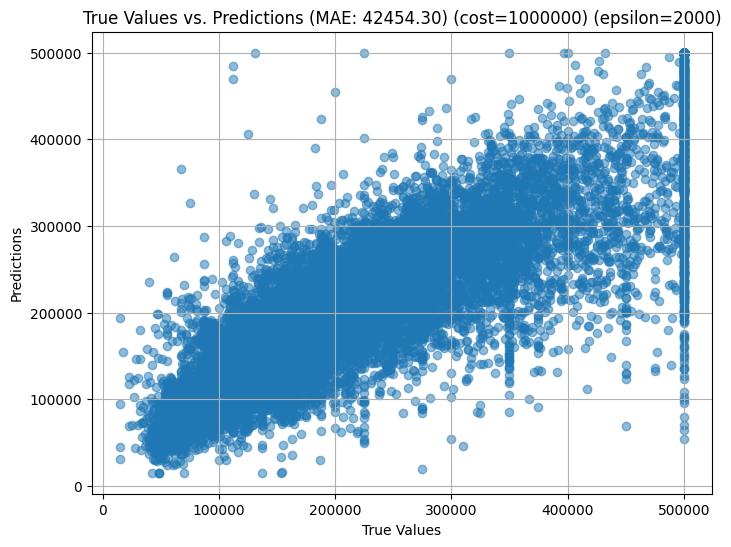

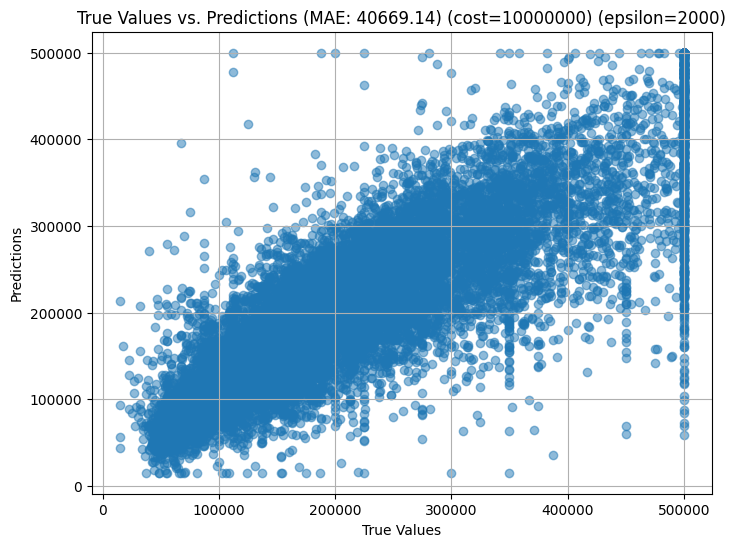

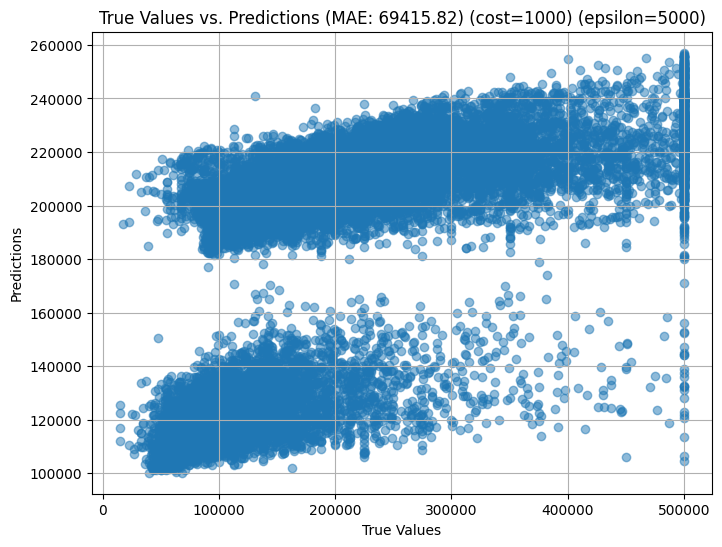

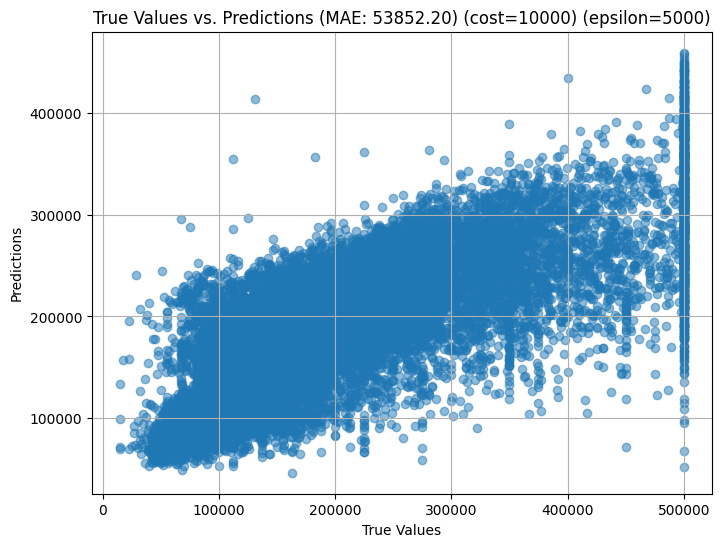

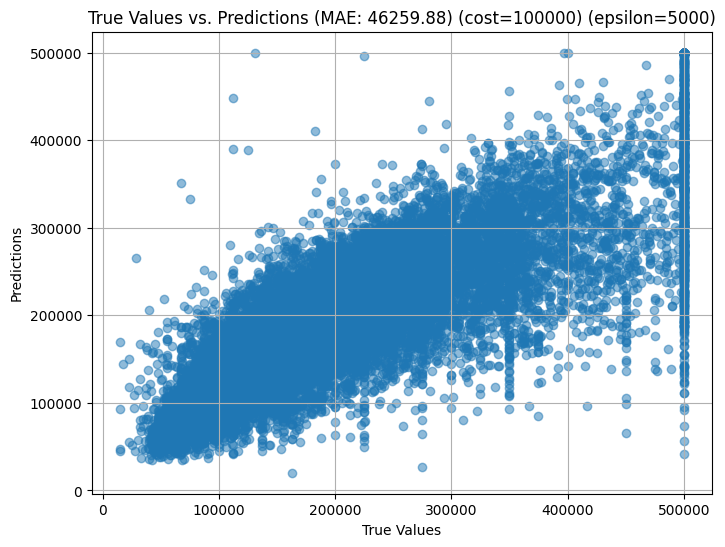

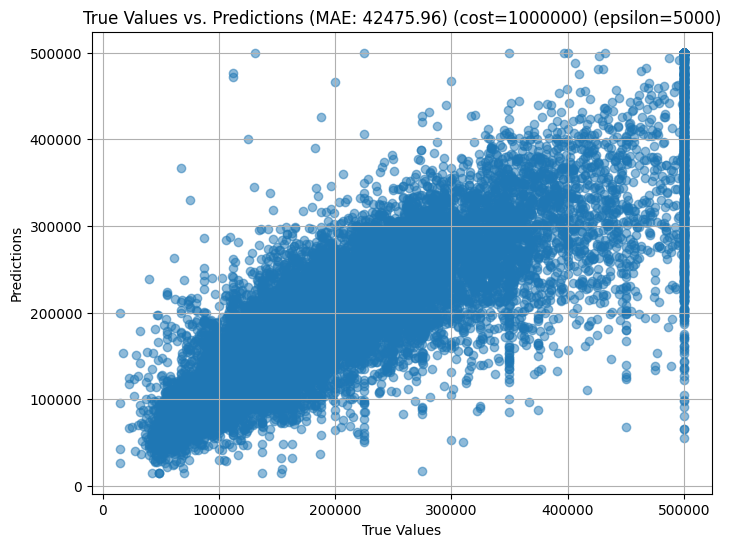

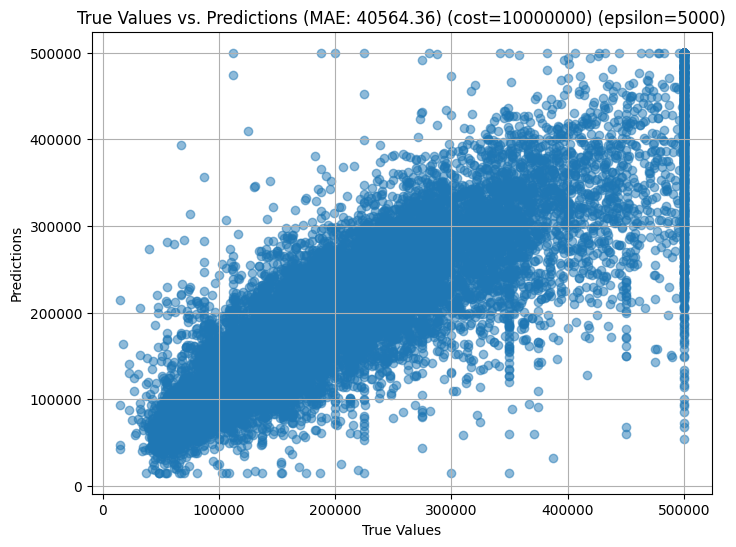

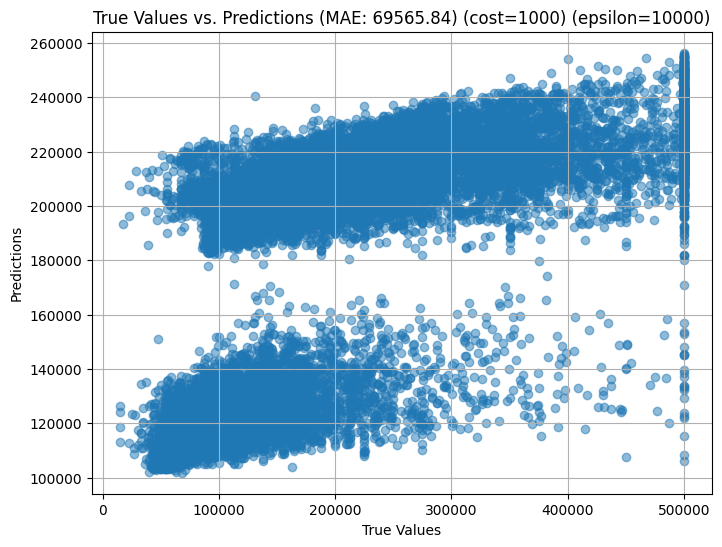

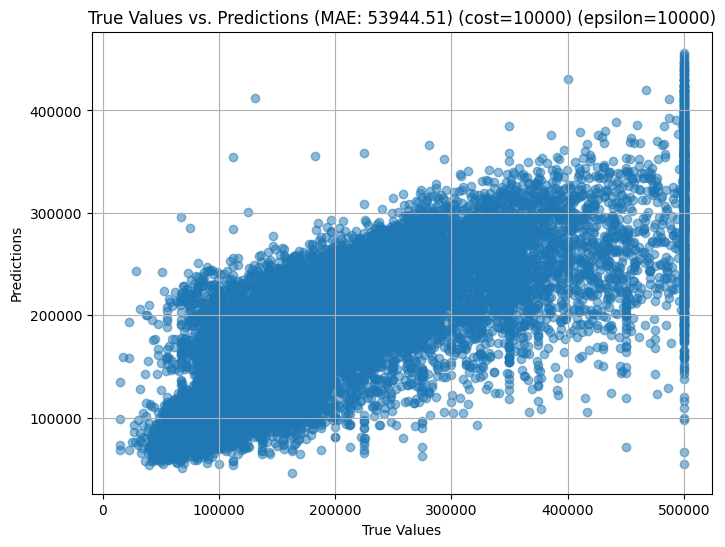

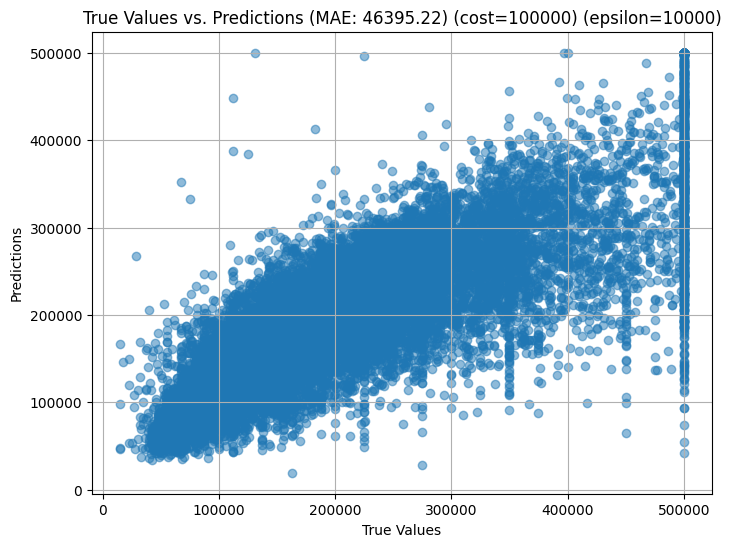

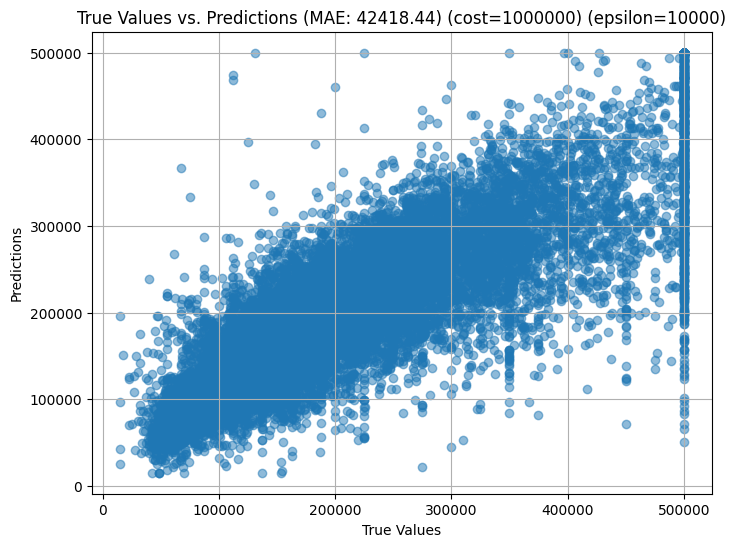

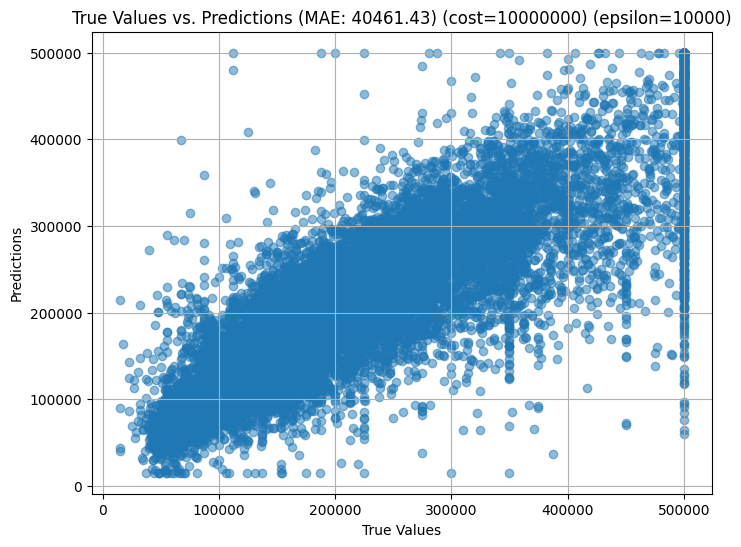

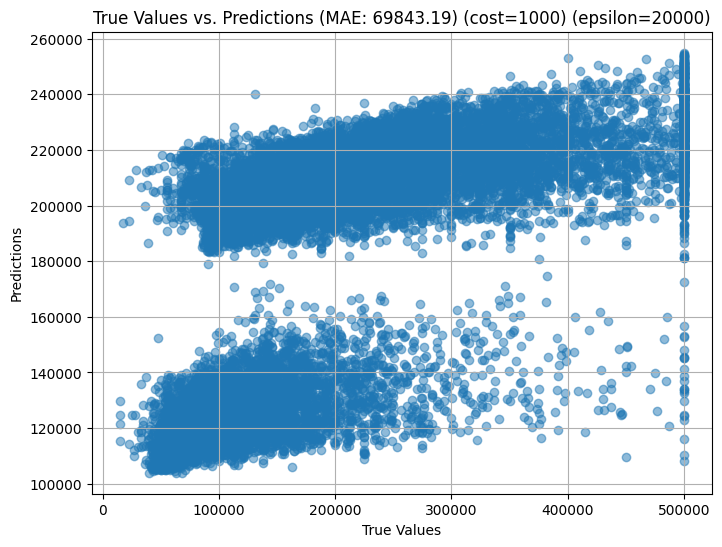

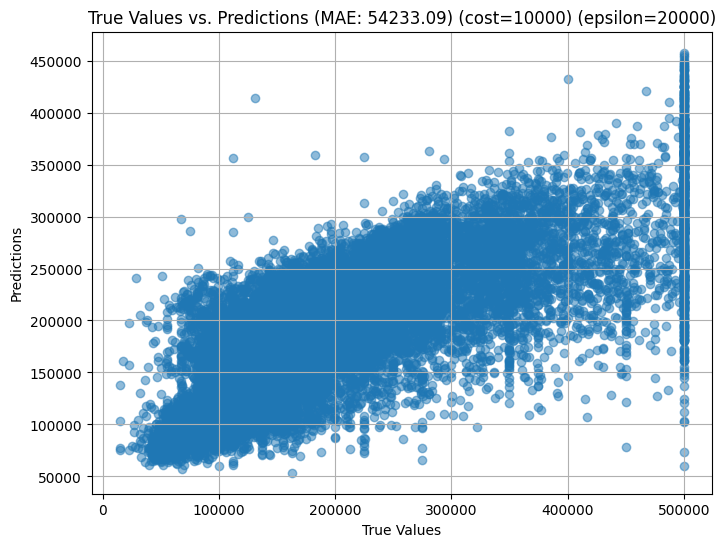

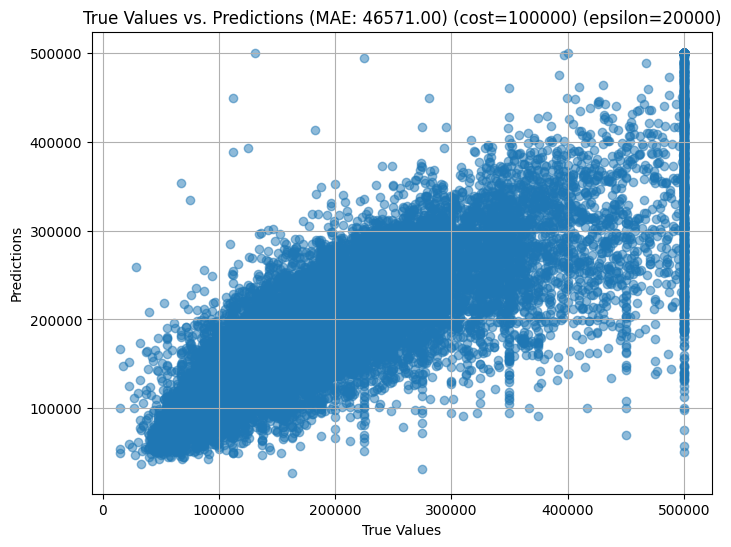

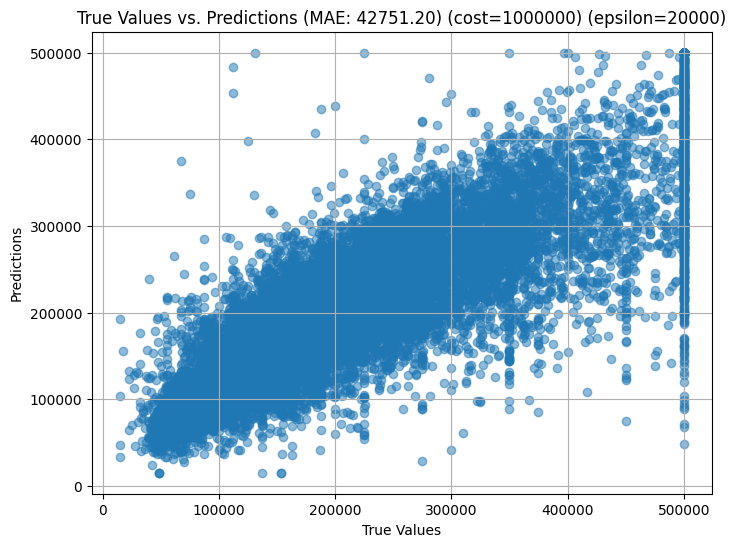

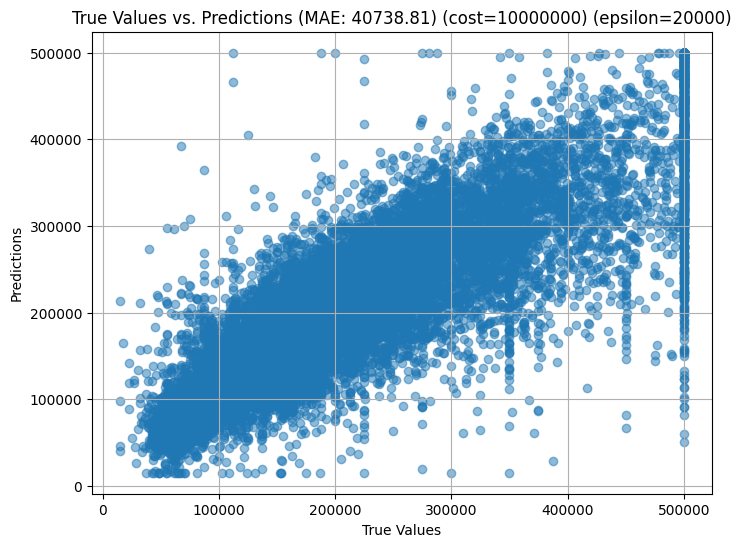

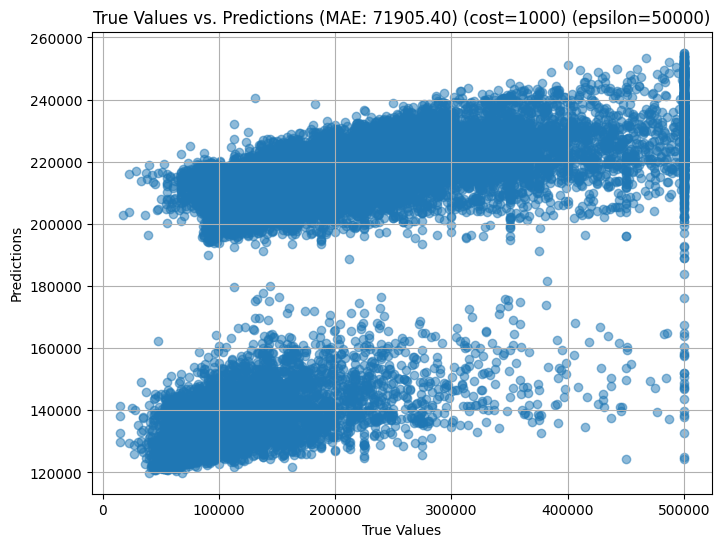

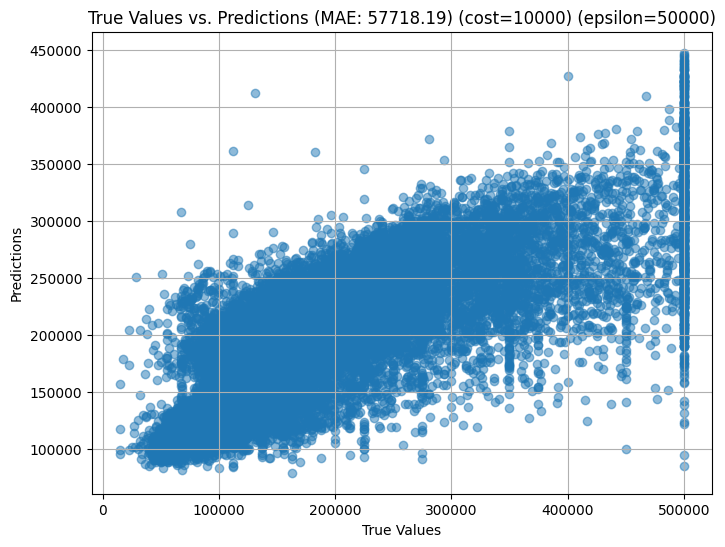

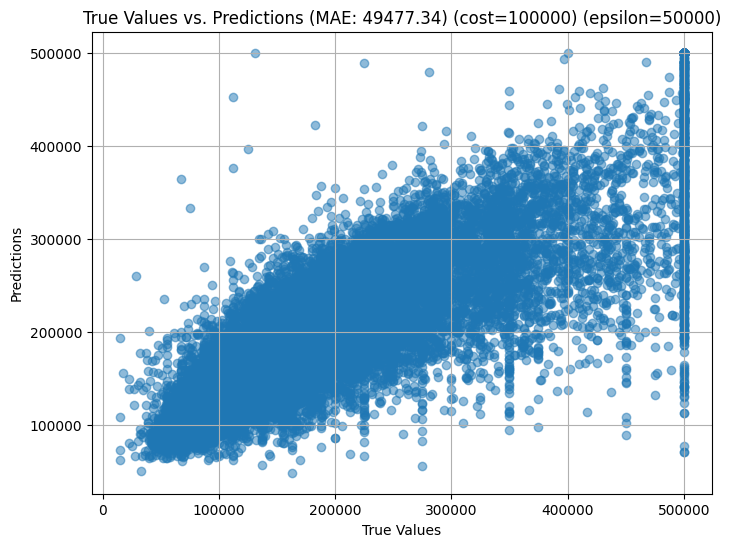

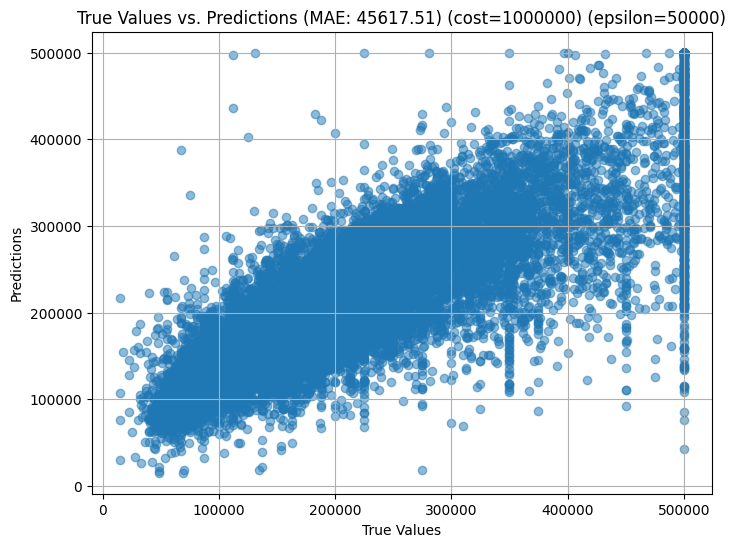

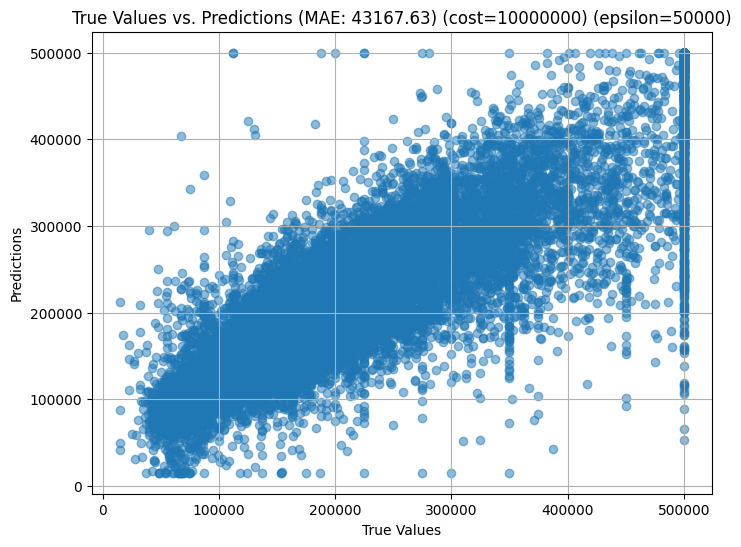

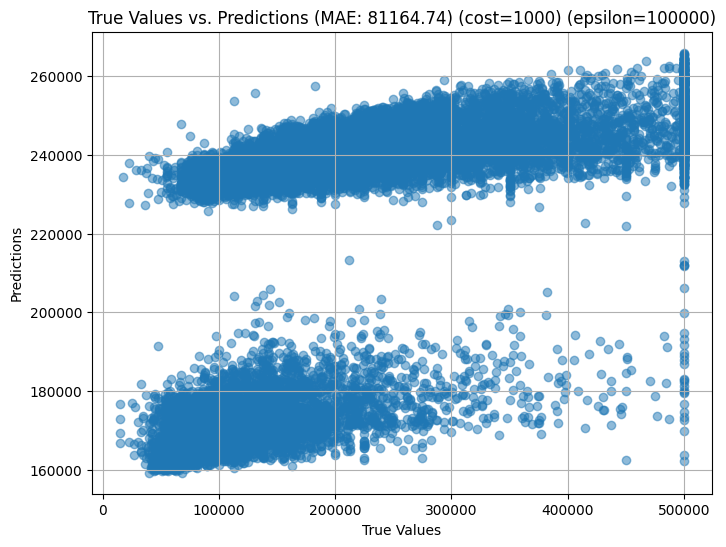

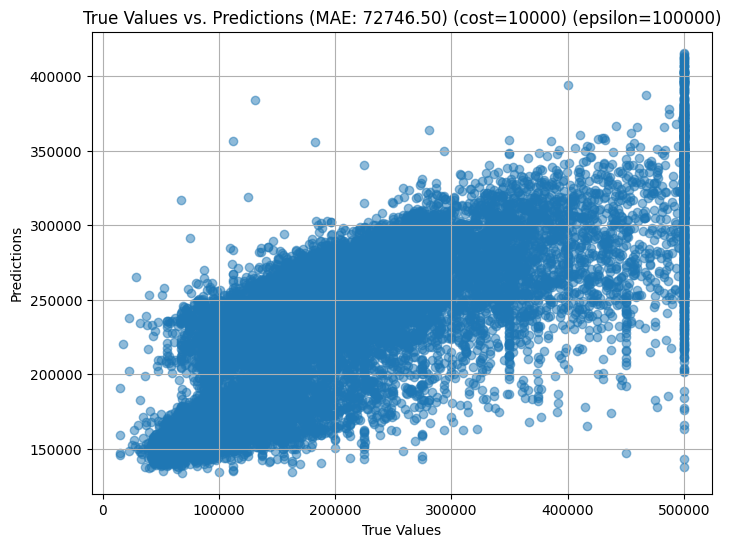

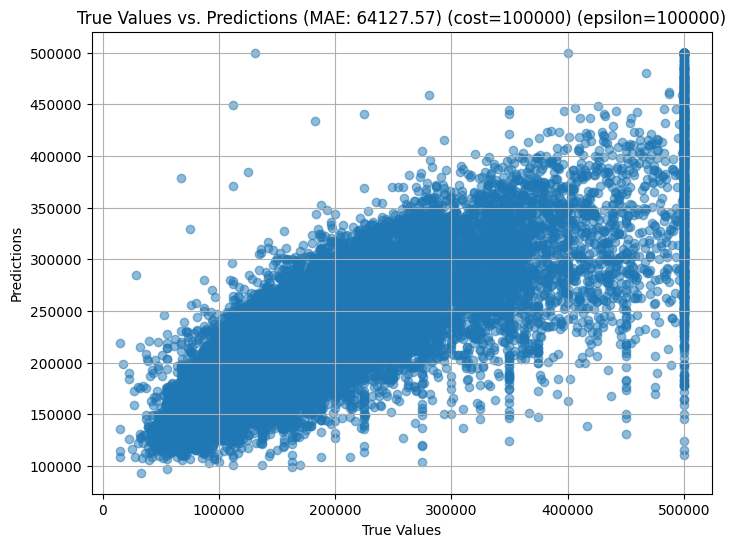

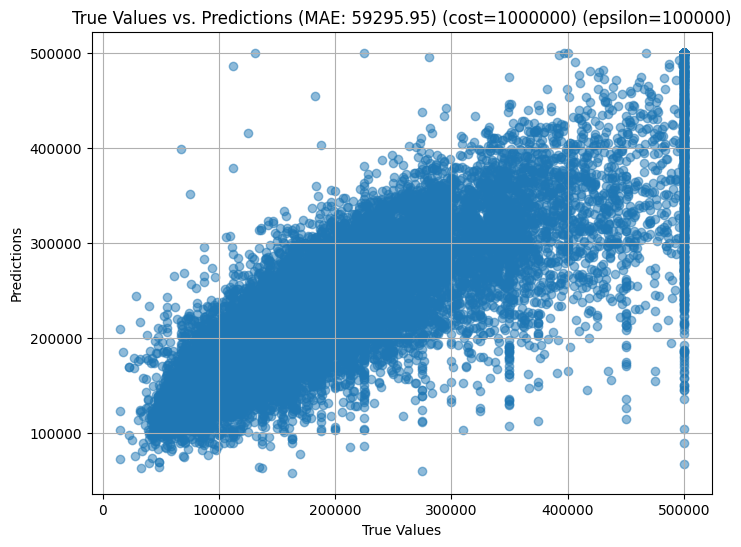

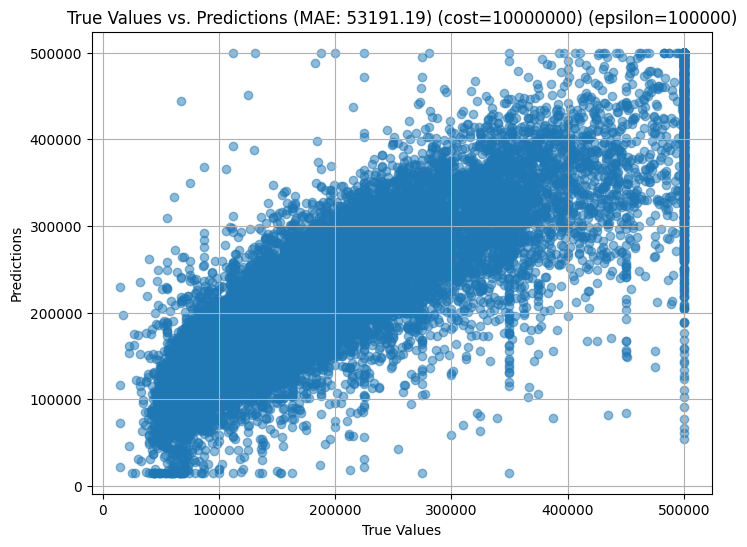

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
X_processed = preprocess_features(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed,y,test_size=0.9, random_state=id)

# cost and epsilons we want to use
costs = [1000,10000,100000,1000000,10000000]
epsilon_values = [2000,5000,10000,20000,50000,100000]

# store mae values
maes = []
for epsilon in epsilon_values:
  for cost in costs:
    svr = SVR(kernel='rbf', gamma='scale', C=cost, epsilon=epsilon)
    mae = run_reg(svr, X_train, X_test, y_train, y_test)
    maes.append(mae)


###Task 4 - MAE visualisation

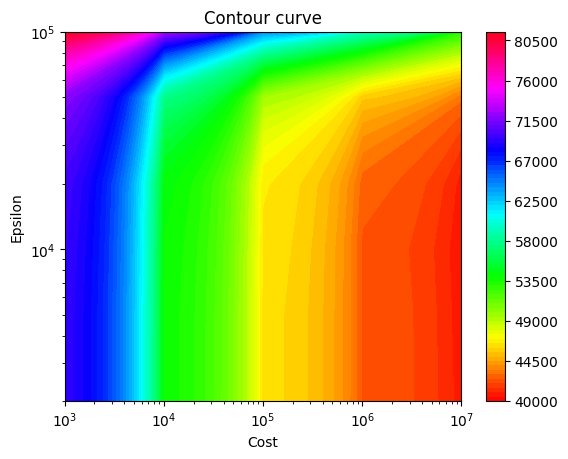

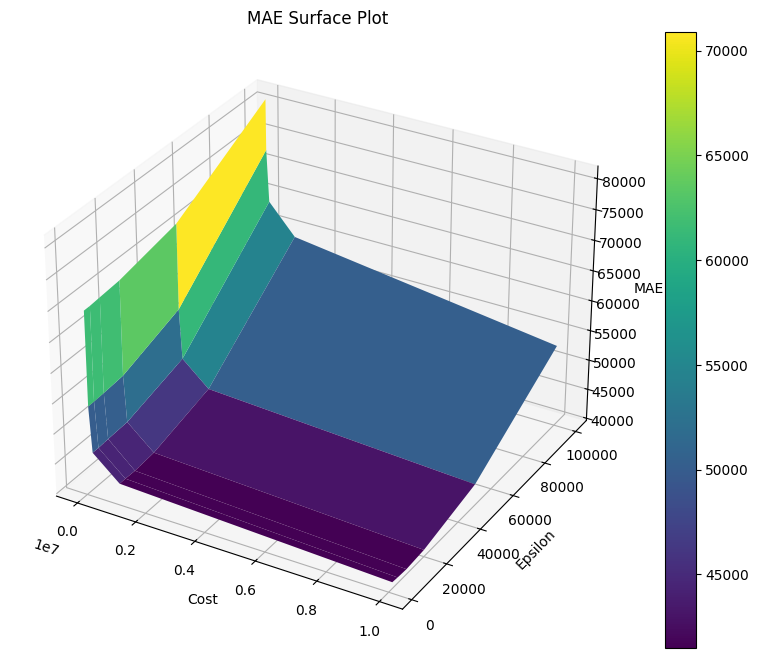

In [5]:
# https://matplotlib.org/stable/gallery/images_contours_and_fields/contour_demo.html
# https://stackoverflow.com/questions/66318314/matplotlib-colorbar-missing-1-required-positional-argument-mappable
import numpy as np
import matplotlib.pyplot as plt

# have to reshape the list to map onto a 5x6 grid (ie epsilon x cost)
maes = np.array(maes)
reshape_maes = maes.reshape(len(epsilon_values),len(costs))

# 2D contour curve (from Lab 7 instructions)
plt.contourf(costs, epsilon_values,reshape_maes,100,cmap='hsv')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()
plt.xlabel('Cost')
plt.ylabel('Epsilon')
plt.title("Contour curve")
plt.show()

# 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

# create grid for 3d contour curve
X_grid, Y_grid = np.meshgrid(costs, epsilon_values)

cs = ax.plot_surface(X_grid, Y_grid, reshape_maes, cmap='viridis')
ax.set_xlabel('Cost')
ax.set_ylabel('Epsilon')
ax.set_zlabel('MAE')
ax.set_title('MAE Surface Plot')
fig.colorbar(cs)
plt.show()

###Task 5 - Discussion

**For what set of parameters is the MAE loss the lowest?**

The lowest MAE was achieved by the model with cost=10,000,000 and epsilon=10,000. The MAE achieved by this model was 40,461.43.

**Is this MAE loss better than the MAE loss you obtained in Lab 5?**

The best performing regression model from Lab 5 had an MAE of 48,798.16, so the best Lab 7 model has better MAE loss.

**Note any interesting observations you have on the effects the
hyperparameters (cost, and epsilon)  has on the test MAE?**

It seems the size of the cost parameter is very significant in determining the model's MAE. There were models with low epsilon values that performed relatively well, but there were no well-performing models that had a small cost parameter. For example, one model with epsilon=2000 achieved an MAE of 40,669.14, comparable to the best performing model described above, while no model with cost=1000 achieved an MAE below 69,000.

The negative of impact of a low cost parameter seemed to be compounded with an increasing epsilion value. The model with cost=1000 and epsilon=2000 had MAE 69,404.27 while the model with cost=1000 and epsilon=100,000 had MAE 81,164.74

**How does the value of the cost hyperparameter relate to underfitting and overfitting?**

Support Vector Regressors are large-margin classifiers, meaning classification is performed/trained by attempting to choose a seperation function (piece-wise function comprises linear functions, for example) which maximises the margin between classes (i.e the maximises the distance in some hyperplane).

One problem with this method is that the separation hyperplane is primarily determined by the subset of datapoints which are closest to other classes (hence, margin). The seperation is therefore affected by sampling noise in the subset and is unlikely to the best seperation for the entire data.

The cost hyperparameter defines the cost attributed to misclassified datapoints, and thus also determines the width of the classifying margin which the model uses. If the cost hyperparameter is very large, the seperating margins will be small and no training datapoints will be misclassified. This will inevitably lead to overfitting. Decreasing the cost hyperparameter will allow some datapoints to be misclassified, but will lead to wider margins which generalise better to unseen data.

**How does the value of the epsilon hyperparameter relate to underfitting and overfitting?**

The epsilon hyperparameter determines the width of a "tube" (see the image here https://medium.com/data-science/understanding-svr-and-epsilon-insensitive-loss-with-scikit-learn-28ec03a3d0d9) around the hyperplane boundary inside which points are considered to be correctly classified, regardless of their position in respect to the boundary. Large epsilon values would cause underfitting.


###Convert to pdf

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get update
!sudo apt-get install pandoc texlive-xetex texlive-fonts-recommended texlive-plain-generic -y
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Lab7-MatthewChristensen-1631625-TobyRoberts-1628189.ipynb"